In [1]:
import os
import json
import sys
sys.path.append("../")

from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
from skmultilearn.model_selection import iterative_train_test_split

/home/joanna/miniconda3/envs/default-env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
data_dir = "../../data/google_patents/us-25000"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 10


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "patent_id": str,
    "title": [{"text": str, "language": str, "truncated": bool}],
    "description": [{"text": str, "language": str, "truncated": bool}],
    "claims": [{"text": str, "language": str, "truncated": bool}],
    "classifications": [{"code": str, "inventive": bool, "first": bool, "tree": List[str]}, ...]
}
```

In [4]:
sample_doc_file = doc_files[0]
with open(sample_doc_file, "r") as f:
    for line in f:
        sample_doc = json.loads(line)
        break
sample_doc["classifications"]

[{'code': 'A46B11/0006', 'inventive': True, 'first': True, 'tree': []},
 {'code': 'A46B9/023', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A45D24/28', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B5/0095', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A45D24/22', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B11/002', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B2200/104', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B9/023', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B2200/104', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A45D24/22', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B11/0006', 'inventive': True, 'first': True, 'tree': []},
 {'code': 'A46B5/0095', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B11/002', 'inventive': False, 'first': False, 'tree': []}]

In [5]:
def tokens(segments):
    res = []
    for c in segments:
        for x in c["text"].split():
            res.append(x)
    return res

def get_id(doc):
    return doc["patent_id"]

def get_content(doc):
    return " ".join(tokens(doc["claims"]))
    
def get_title(doc):
    return " ".join(tokens(doc["title"]))
    
def get_description(doc):
    return " ".join(tokens(doc["description"]))
    
def get_label(doc):
    return list(set(x["code"][:3] for x in doc["classifications"]))

def get_sample(doc):
    return {
        "id": get_id(doc), "title": get_title(doc), 
        "desc": get_description(doc), "content": get_content(doc), 
        "labels": get_label(doc)
    }

In [6]:
"""
Extract samples from raw data
"""
samples = []
for fname in doc_files:
    with open(fname, "r") as f:
        for line in f:
            doc = json.loads(line)
            if get_label(doc) and get_content(doc):
                samples.append(get_sample(doc))
 
print("Number of valid documents:", len(samples))

Number of valid documents: 17952


In [7]:
"""
Count number of samples/label and discard labels with < 500 samples
"""
def compute_frequency(samples):
    freq = {}
    for x in samples:
        for label in x["labels"]:
            freq[label] = freq.get(label, 0) + 1
    return freq

freq = compute_frequency(samples)
labels = set(k for k, v in freq.items() if v >= 200)
label_ids = {x : i for i, x in enumerate(labels)}
print("Number of labels:", len(labels))

Number of labels: 34


In [8]:
new_samples = []
for sample in tqdm(samples):
    sample["labels"] = [e for e in sample["labels"] if e in labels]
    if len(sample["labels"]) != 0:
        new_samples.append(sample)

samples = new_samples
print("Number of samples:", len(samples))

100%|██████████| 17952/17952 [00:00<00:00, 496257.42it/s]

Number of samples: 16451


## EDA

In [9]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,desc,content,labels
0,US-10033661-B1,Tiered priority system and callout performance...,BACKGROUND OF THE INVENTION The present invent...,What is claimed is: 1. A method comprising: re...,"[G06, H04]"
1,US-10027048-B2,Electrical component and electronic device,CROSS REFERENCE TO RELATED APPLICATIONS This a...,What is claimed is: 1. An electrical component...,[H01]
2,US-10077129-B2,Labeler with sealing label press-on device,CROSS-REFERENCE TO RELATED APPLICATIONS This A...,What is claimed is: 1. A labeler comprising: a...,[B65]
3,US-10193177-B2,Fuel cell system and operating method therefor,CROSS-REFERENCE TO RELATED APPLICATIONS This i...,The invention claimed is: 1. A residual water ...,"[H01, Y02]"
4,US-10147384-B2,Boosting voltage generator and a display appar...,CROSS-REFERENCE TO RELATED APPLICATION This ap...,What is claimed is: 1. A boosting voltage gene...,[G09]
...,...,...,...,...,...
16446,US-10235166-B1,Code quality evaluation and user interfaces,BACKGROUND In many software development enviro...,What is claimed is: 1. A method of generating ...,[G06]
16447,US-10030890-B2,Hinge apparatus,CROSS-REFERENCE TO RELATED APPLICATIONS This a...,What is claimed is: 1. A hinge apparatus for m...,"[F16, G09]"
16448,US-10076584-B2,Low odor latex paint capable of reducing inter...,CROSS REFERENCE TO RELATED APPLICATIONS This a...,What is claimed is: 1. A paint composition com...,"[A61, C08, C09, Y10]"
16449,US-10066520-B2,Valve opening and closing timing control appar...,CROSS REFERENCE TO RELATED APPLICATIONS This a...,What is claimed is: 1. A valve opening and clo...,[F01]


In [10]:
print(df["content"].iloc[0])

What is claimed is: 1. A method comprising: receiving a call from a first online transaction program (first OTP); in response to receiving the call: generating an express socket path, generating a dispatchable unit of work and a corresponding token identifier (token ID), sending the token ID to the first OTP; receiving, from the first OTP a first callout message, where the first callout message includes the token ID; sending the first callout message on the express socket path; receiving a first response corresponding to the first callout message; sending the first response to the first OTP; receiving, from the first OTP a second callout message, where the second callout message includes the token ID; sending the second callout message on the express socket path; receiving, a second response corresponding to the second callout message; sending the second response to the first OTP; receiving a signal indicating that the first OTP has terminated; in response to receiving the signal, term

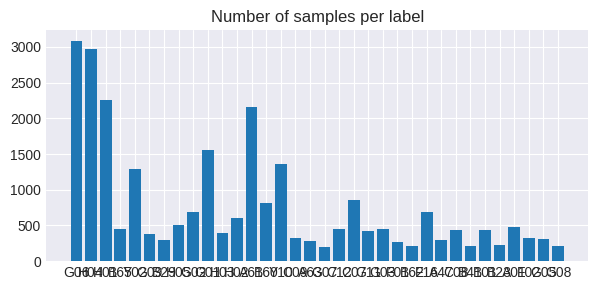

In [11]:
freq = compute_frequency(samples)
fig = plt.figure(figsize=(7, 3))
plt.bar(freq.keys(), freq.values())
plt.title("Number of samples per label")
plt.show()

In [12]:
threshold = 200
print("Threshold:", threshold)

def pivot(arr, keys):
    global sample_label
    a, b = [], []
    for x in arr:
        if keys.intersection(sample_label[x]):
            b.append(x)
        else:
            a.append(x)
    a.extend(b)
    return a

Threshold: 200


In [13]:
class_label = defaultdict(set)
sample_label = defaultdict(set)
predominant_labels = set(["Y10", "G06"])

for rid, labels in df["labels"].iteritems():
    sample_label[rid].update(labels)
    for x in labels:
        class_label[x].add(rid)

selected_samples = set()
selected_labels = set()

for label in sorted(freq, key=lambda x : freq.get(x)):
    if len(class_label[label]) <= threshold:
        selected_samples.update(class_label[label])
        selected_labels.add(label)
        continue

    # compute number of samples needed to be drawn (ignoring duplicated samples)
    included_samples = class_label[label].intersection(selected_samples)
    sample_size = max(0, threshold - len(included_samples))

    # samples that contain least unselected labels have the highest priority
    sample_space = list(class_label[label].difference(selected_samples))
    sorted_sample_space = sorted(sample_space, key=lambda x : len(sample_label[x].difference(selected_labels)))
    sorted_sample_space = pivot(sorted_sample_space, predominant_labels)
    choices = random_state.choice(sorted_sample_space[:sample_size + 50], sample_size, replace=False)
    
    selected_samples.update(choices)
    selected_labels.add(label)

new_samples = [x for i, x in enumerate(samples) if i in selected_samples]

In [14]:
len(new_samples)

4440

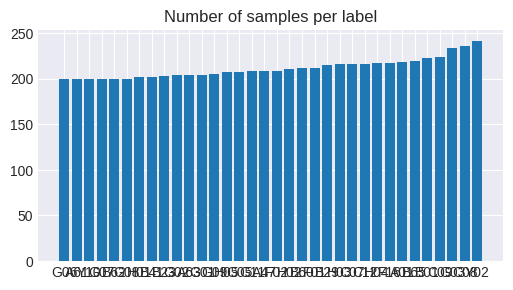

count     34.000000
mean     211.411765
std       10.745309
min      200.000000
25%      203.250000
50%      208.000000
75%      216.750000
max      241.000000
dtype: float64

In [15]:
new_freq = compute_frequency(new_samples)
new_freq = {k: new_freq[k] for k in sorted(new_freq, key=new_freq.get)}
fig = plt.figure(figsize=(6, 3))
plt.bar(new_freq.keys(), new_freq.values())
plt.title("Number of samples per label")
plt.show()
pd.Series(new_freq).describe()

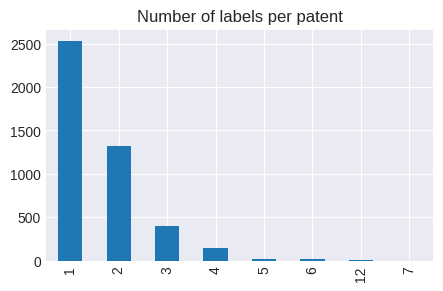

count    4440.000000
mean        1.618919
std         0.891906
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        12.000000
Name: labels, dtype: float64

In [16]:
new_df = pd.DataFrame(new_samples)
fig = plt.figure(figsize=(5, 3))
ax = new_df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()
new_df["labels"].apply(lambda x : len(x)).describe()

## Data Splitting

In [17]:
df = new_df
samples = new_samples

In [18]:
X_raw = np.array([[x] for x in samples])
y_raw = np.matrix([utils.get_onehot(x["labels"], label_ids) for x in samples])
X, y = {}, {}
y_raw.shape

(4440, 34)

In [19]:
X["train"], y["train"], X["test"], y["test"] = iterative_train_test_split(X_raw, y_raw, test_size=0.1)

In [20]:
# Make sure all sets share the same set of labels
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["test"] == 1)[1]).tolist()))

set()

In [21]:
X["train"], y["train"], X["dev"], y["dev"] = iterative_train_test_split(X["train"], y["train"], test_size=len(y["test"]) / len(y["train"]))

In [22]:
# Make sure all sets share the same set of labels
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["dev"] == 1)[1]).tolist()))

set()

In [23]:
samples = []
for data_type in ("train", "dev", "test"):
    for sample in X[data_type]:
        sample = sample[0]
        sample["is_train"] = sample["is_dev"] = sample["is_test"] = False
        sample[f"is_{data_type}"] = True
        samples.append(sample)

In [24]:
df = pd.DataFrame(samples)
df.head()

,id,title,desc,content,labels,is_train,is_dev,is_test
0,US-10089316-B1,Managing multiple file system expansions,BACKGROUND Data storage systems are arrangemen...,What is claimed is: 1. A method of managing mu...,[G06],True,False,False
1,US-10048471-B2,"Photographing system, image capturing unit and...",RELATED APPLICATIONS This application is a con...,What is claimed is: 1. A photographing system ...,[G02],True,False,False
2,US-10103729-B2,Auxiliary commutated silicon-controlled rectif...,BACKGROUND An electrical load which receives p...,What is claimed is: 1. A device comprising: a ...,"[H03, H02]",True,False,False
3,US-10153439-B2,Charge transport material,TECHNICAL FIELD This invention relates to a ch...,The invention claimed is: 1. A charge-transpor...,"[H01, C09, H05]",True,False,False
4,US-2006144720-A1,Chemical sensors,RELATED APPLICATION This application claims pr...,1 . A method for detecting one or more metals ...,[G01],True,False,False


In [25]:
num_words = int(df["content"].apply(lambda x : len(x.split())).mean())
num_chars = int(df["content"].apply(lambda x : sum(1 for e in x if e.strip())).mean())
num_train = len(df[df["is_train"] == True])
num_val = len(df[df["is_dev"] == True])
num_test = len(df[df["is_test"] == True])
num_labels = len(label_ids)
print("{} & {} & {} & {} & {} & {}".format(num_train, num_val, num_test, num_words, num_chars, num_labels))

3566 & 436 & 438 & 920 & 4609 & 34


In [26]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(3566, 436, 438)

In [27]:
# Check if there is any empty patent
df[df["content"].apply(lambda x : len(x)) == 0]

,id,title,desc,content,labels,is_train,is_dev,is_test


## Save data

In [28]:
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")
utils.dump_json(label_ids, save_label_path)

100%|██████████| 4440/4440 [00:01<00:00, 2333.55it/s]
